# Flow Matching

## Data

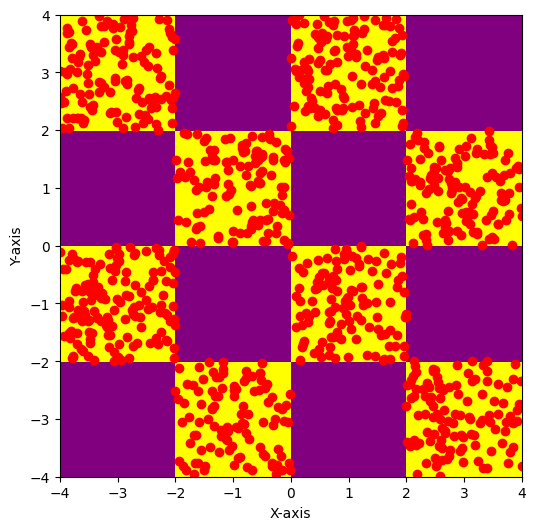

In [1]:
import tqdm
import math
import torch
import numpy as np
from torch import nn
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Parameters
N = 1000  # Number of points to sample
x_min, x_max = -4, 4
y_min, y_max = -4, 4
resolution = 100  # Resolution of the grid

# Create the grid
x = np.linspace(x_min, x_max, resolution)
y = np.linspace(y_min, y_max, resolution)
X, Y = np.meshgrid(x, y)

# Checkerboard pattern
length = 4
checkerboard = np.indices((length, length)).sum(axis=0) % 2

# Sample points in regions where checkerboard pattern is 1
sampled_points = []
while len(sampled_points) < N:
    # Randomly sample a point within the x and y range
    x_sample = np.random.uniform(x_min, x_max)
    y_sample = np.random.uniform(y_min, y_max)

    # Determine the closest grid index
    i = int((x_sample - x_min) / (x_max - x_min) * length)
    j = int((y_sample - y_min) / (y_max - y_min) * length)

    # Check if the sampled point is in a region where checkerboard == 1
    if checkerboard[j, i] == 1:
        sampled_points.append((x_sample, y_sample))

# Convert to NumPy array for easier plotting
sampled_points = np.array(sampled_points)

# Plot the checkerboard pattern
plt.figure(figsize=(6, 6))
plt.imshow(checkerboard, extent=(x_min, x_max, y_min, y_max), origin="lower", cmap=ListedColormap(["purple", "yellow"]))

# Plot sampled points
plt.scatter(sampled_points[:, 0], sampled_points[:, 1], color="red", marker="o")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.show()

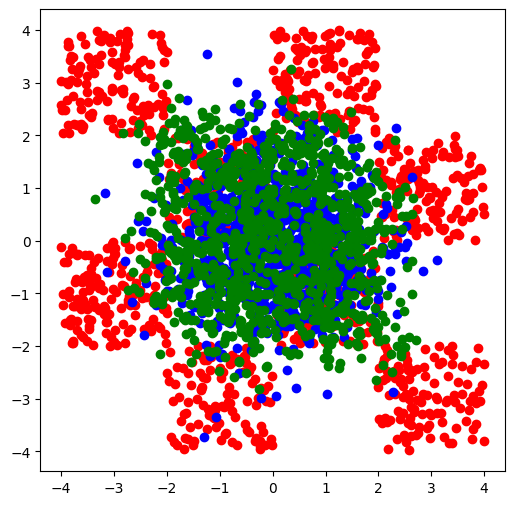

In [2]:
t = 0.5
noise = np.random.randn(N, 2)
plt.figure(figsize=(6, 6))
plt.scatter(sampled_points[:, 0], sampled_points[:, 1], color="red", marker="o")
plt.scatter(noise[:, 0], noise[:, 1], color="blue", marker="o")
plt.scatter((1 - t) * noise[:, 0] + t * sampled_points[:, 0], (1 - t) * noise[:, 1] + t * sampled_points[:, 1], color="green", marker="o")
plt.show()

## Model

In [3]:
class Block(nn.Module):
    def __init__(self, channels=512):
        super().__init__()
        self.ff = nn.Linear(channels, channels)
        self.act = nn.ReLU()

    def forward(self, x):
        return self.act(self.ff(x))

class MLP(nn.Module):
    def __init__(self, channels_data=2, layers=5, channels=512, channels_t=512):
        super().__init__()
        self.channels_t = channels_t
        self.in_projection = nn.Linear(channels_data, channels)
        self.t_projection = nn.Linear(channels_t, channels)
        self.blocks = nn.Sequential(*[
            Block(channels) for _ in range(layers)
        ])
        self.out_projection = nn.Linear(channels, channels_data)

    def gen_t_embedding(self, t, max_positions=10000):
        t = t * max_positions
        half_dim = self.channels_t // 2
        emb = math.log(max_positions) / (half_dim - 1)
        emb = torch.arange(half_dim, device=t.device).float().mul(-emb).exp()
        emb = t[:, None] * emb[None, :]
        emb = torch.cat([emb.sin(), emb.cos()], dim=1)
        if self.channels_t % 2 == 1:  # zero pad
            emb = nn.functional.pad(emb, (0, 1), mode='constant')
        return emb

    def forward(self, x, t):
        x = self.in_projection(x)
        t = self.gen_t_embedding(t)
        t = self.t_projection(t)
        x = x + t
        x = self.blocks(x)
        x = self.out_projection(x)
        return x

In [4]:
model = MLP(layers=5, channels=512)
optim = torch.optim.AdamW(model.parameters(), lr=1e-4)

### Load Pretrained Model for 500k Steps

In [6]:
# If you don't want to train yourself, just load a pretrained model which trained for 500k steps.
ckpt = torch.load("model_500k.pt")
model.load_state_dict(ckpt)

<All keys matched successfully>

## Training

In [7]:
data = torch.Tensor(sampled_points)
training_steps = 100_000
batch_size = 64
pbar = tqdm.tqdm(range(training_steps))
losses = []
for i in pbar:
    x1 = data[torch.randint(data.size(0), (batch_size,))]
    x0 = torch.randn_like(x1)
    target = x1 - x0
    t = torch.rand(x1.size(0))
    xt = (1 - t[:, None]) * x0 + t[:, None] * x1
    pred = model(xt, t)  # also add t here
    loss = ((target - pred)**2).mean()
    loss.backward()
    optim.step()
    optim.zero_grad()
    pbar.set_postfix(loss=loss.item())
    losses.append(loss.item())

100%|██████████| 100000/100000 [1:11:14<00:00, 23.40it/s, loss=2.96]


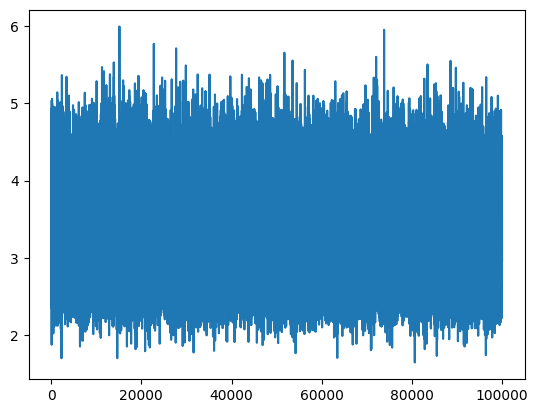

In [8]:
plt.plot(losses)

## Sampling

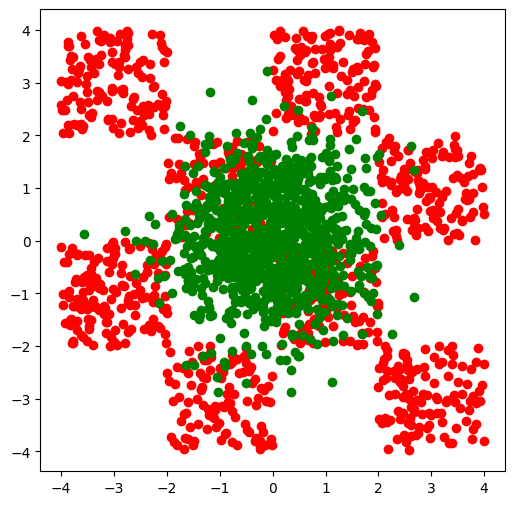

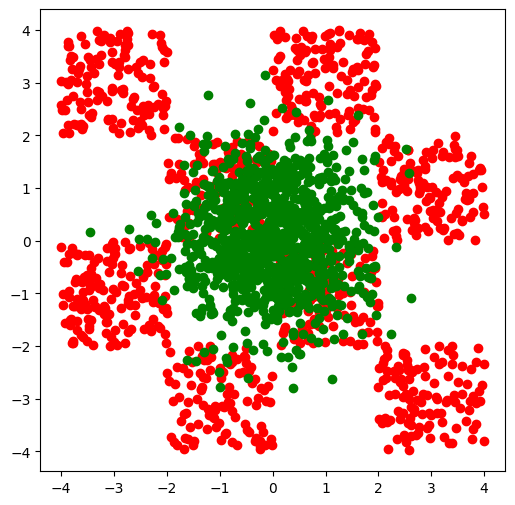

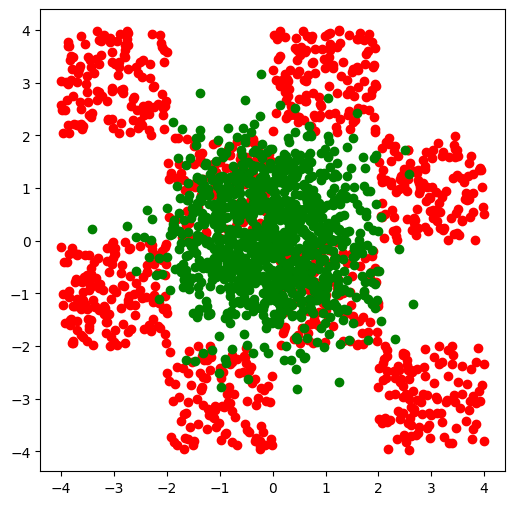

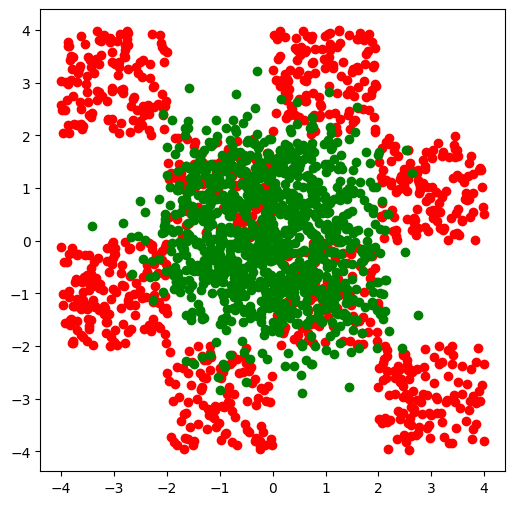

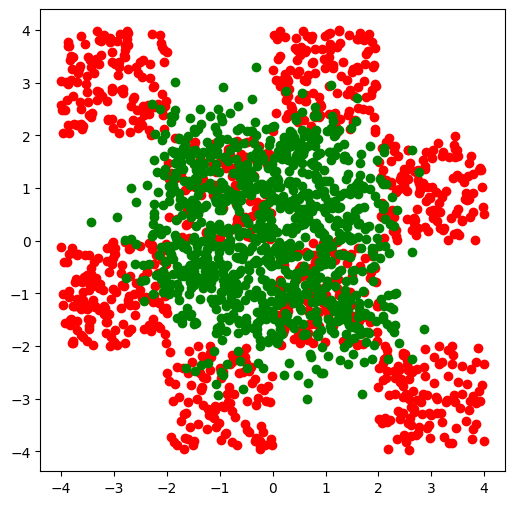

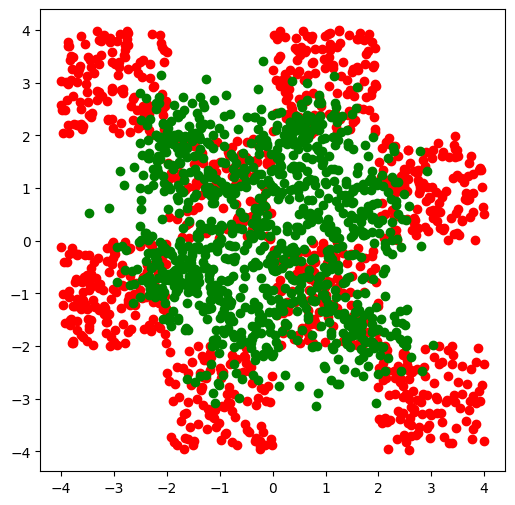

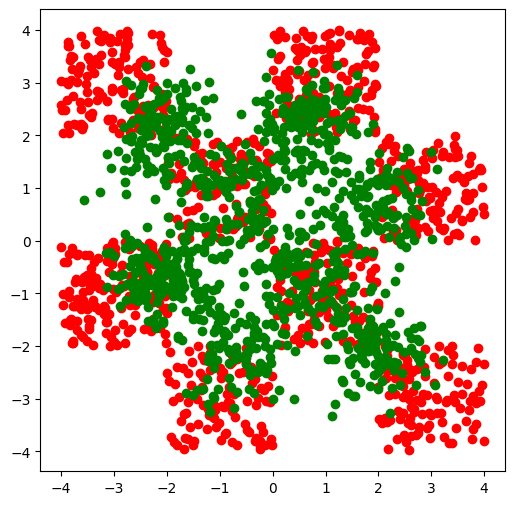

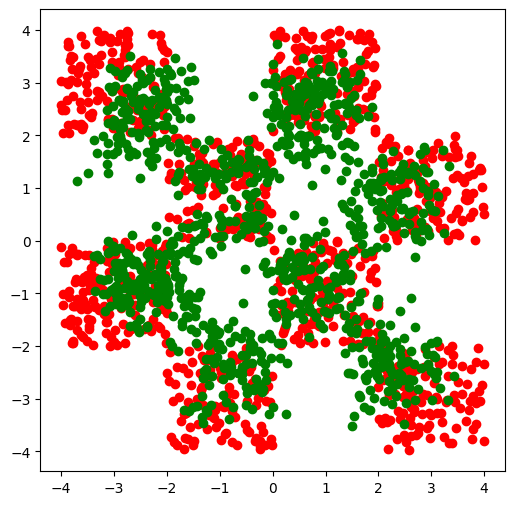

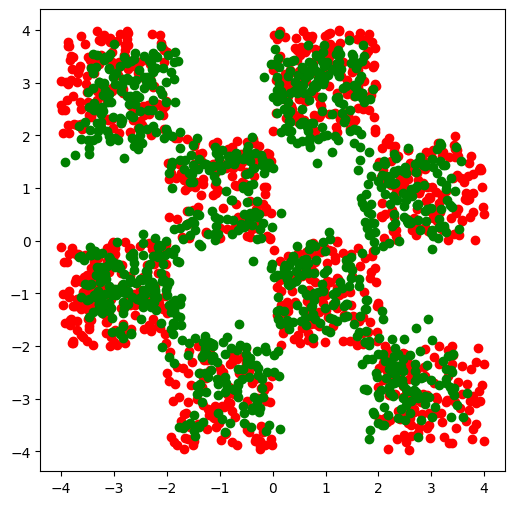

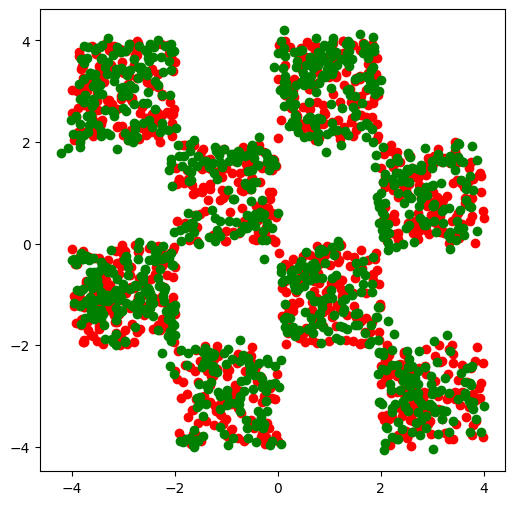

Done Sampling


In [9]:
torch.manual_seed(42)
model.eval().requires_grad_(False)
xt = torch.randn(1000, 2)
steps = 1000
plot_every = 100
for i, t in enumerate(torch.linspace(0, 1, steps), start=1):
    pred = model(xt, t.expand(xt.size(0)))
    xt = xt + (1 / steps) * pred
    if i % plot_every == 0:
        plt.figure(figsize=(6, 6))
        plt.scatter(sampled_points[:, 0], sampled_points[:, 1], color="red", marker="o")
        plt.scatter(xt[:, 0], xt[:, 1], color="green", marker="o")
        plt.show()
model.train().requires_grad_(True)
print("Done Sampling")